#  Sequence to Sequence Network with Attention
Applied to translation

In this project we will be teaching a neural network to translate from
French to English.

::

    [KEY: > input, = target, < output]

    > il est en train de peindre un tableau .
    = he is painting a picture .
    < he is painting a picture .

    > pourquoi ne pas essayer ce vin delicieux ?
    = why not try that delicious wine ?
    < why not try that delicious wine ?

    > elle n est pas poete mais romanciere .
    = she is not a poet but a novelist .
    < she not not a poet but a novelist .

    > vous etes trop maigre .
    = you re too skinny .
    < you re all alone .

... to varying degrees of success.

This is made possible by the simple but powerful idea of the [sequence
to sequence network](https://arxiv.org/abs/1409.3215>), in which two
recurrent neural networks work together to transform one sequence to
another. An encoder network condenses an input sequence into a vector,
and a decoder network unfolds that vector into a new sequence.

![](imgs/seq2seq.png)

To improve upon this model we'll use an [attention
mechanism](https://arxiv.org/abs/1409.0473), which lets the decoder
learn to focus over a specific range of the input sequence.

In [1]:
from __future__ import unicode_literals, print_function, division
from io import open
import unicodedata
import string
import re
import random

import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import numpy as np
%matplotlib inline

## Loading data files
The data for this project is a set of many thousands of English to
French translation pairs.

In [2]:
def download_dataset():
    #! wget https://download.pytorch.org/tutorial/data.zip
    ! wget https://www.manythings.org/anki/spa-eng.zip
    #! unzip data.zip
    !unzip spa-eng.zip
    !mv _about.txt spa.txt data

In [3]:
# to download the dataset
#download_dataset()

We will be representing each word in a language as a one-hot
vector, or giant vector of zeros except for a single one (at the index
of the word). 
![](imgs/word-encoding.png) 

We'll need a unique index per word to use as the inputs and targets of
the networks later. To keep track of all this we will use a helper class
called ``Lang`` which has word → index (``word2index``) and index → word
(``index2word``) dictionaries, as well as a count of each word
``word2count`` to use to later replace rare words.

In [4]:
SOS_token = 1
EOS_token = 2
class Lang:
    def __init__(self, name):
        self.name = name
        self.word2index = {"PAD": 0, "SOS": 1, "EOS": 2, "UNK": 3}
        self.word2count = {}
        self.index2word = {0: "PAD", 1: "SOS", 2: "EOS", 3: "UNK"}
        self.n_words = 4  # Count SOS and EOS

    def addSentence(self, sentence):
        for word in sentence.split(' '):
            self.addWord(word)

    def addWord(self, word):
        if word not in self.word2index:
            self.word2index[word] = self.n_words
            self.word2count[word] = 1
            self.index2word[self.n_words] = word
            self.n_words += 1
        else:
            self.word2count[word] += 1

The files are all in Unicode, to simplify we will turn Unicode
characters to ASCII, make everything lowercase, and trim most
punctuation.




In [5]:
def unicodeToAscii(s):
    """Turn a Unicode string to plain ASCII
    
    https://stackoverflow.com/a/518232/2809427
    """
    return ''.join(c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
    )

def normalizeString(s):
    """Lowercase, trim, and remove non-letter characters"""
    s = unicodeToAscii(s.lower().strip())
    s = re.sub(r"([.!?])", r" \1", s)
    s = re.sub(r"[^a-zA-Z.!?]+", r" ", s)
    return s

In [6]:
def readLangs(filename):
    # Read the file and split into lines
    lines = open(filename).read().strip().split('\n')

    # Split every line into pairs and normalize
    pairs = [[normalizeString(s) for s in l.split('\t')] for l in lines]

    return pairs

Since there are a *lot* of example sentences and we want to train
something quickly, we'll trim the data set to only relatively short and
simple sentences. Here the maximum length is 10 words (that includes
ending punctuation) and we're filtering to sentences that translate to
the form "We are" and "They are". (accounting for apostrophes replaced
earlier).




In [321]:
MAX_LENGTH = 10

eng_prefixes = (
    "i am ", "i m ",
    "he is", "he s ",
    "she is", "she s ",
    "you are", "you re ",
    "we are", "we re ",
    "they are", "they re "
)

def filterPair(p):
    return len(p[0].split(' ')) < MAX_LENGTH and \
        len(p[1].split(' ')) < MAX_LENGTH and \
        p[0].startswith(eng_prefixes)


def filterPairs(pairs):
    return [pair for pair in pairs if filterPair(pair)]

The full process for preparing the data is:

-  Read text file and split into lines, split lines into pairs
-  Normalize text, filter by length and content
-  Make word lists from sentences in pairs




In [322]:
pairs = readLangs("data/eng-fra.txt")
print("Read %s sentence pairs" % len(pairs))
pairs = filterPairs(pairs)
print("Trimmed to %s sentence pairs" % len(pairs))

Read 135842 sentence pairs
Trimmed to 10599 sentence pairs


In [323]:
def prepareData(data_filename):
    pairs = readLangs(data_filename)
    print("Read %s sentence pairs" % len(pairs))
    pairs = filterPairs(pairs)
    print("Trimmed to %s sentence pairs" % len(pairs))
    
    
    #randomize the data with a fixed seed for repeatability
    random.seed(4)
    random.shuffle(pairs)
    #choose the first 10 pairs for testing and the rest for training
    valid_pairs = pairs[0:200]
    train_pairs = pairs[200:len(pairs)]
    
    print("number of test pairs: %s" % len(valid_pairs))
    print("number of train pairs: %s" % len(train_pairs))
    
    input_lang = Lang("english")
    output_lang = Lang("french")
    
    print("Counting words...")
    cnt = 0
    for pair in pairs:
        input_lang.addSentence(pair[1])
        output_lang.addSentence(pair[0])
        
    print("Counted words:")
    print(input_lang.name, input_lang.n_words)
    print(output_lang.name, output_lang.n_words)
    return input_lang, output_lang, pairs, train_pairs, valid_pairs

input_lang, output_lang, pairs, train_pairs, valid_pairs = prepareData("data/eng-fra.txt")
random.seed(4)
print(random.choice(pairs))

Read 135842 sentence pairs
Trimmed to 10599 sentence pairs
number of test pairs: 10
number of train pairs: 10589
Counting words...
Counted words:
english 4347
french 2805
['he s the love of my life .', 'c est l amour de ma vie .']


In [270]:
train_pairs[0]

['we re going down .', 'nous descendons .']

# Dataset

In [324]:
def encode_sentence(s, vocab2index, N=12, padding_start=True):
    enc = np.zeros(N, dtype=np.int32)
    enc1 = np.array([SOS_token] + [vocab2index.get(w, vocab2index["UNK"]) for w in s.split()] + [EOS_token])
    l = min(N, len(enc1))
    if padding_start:
        enc[:l] = enc1[:l]
    else:
        enc[N-l:] = enc1[:l]
    return enc, l

In [325]:
train_pairs[0]

['you re bright .', 'tu es brillante .']

In [326]:
encode_sentence(train_pairs[0][0], input_lang.word2index, padding_start=False)

(array([ 0,  0,  0,  0,  0,  0,  1,  3,  3,  3, 12,  2], dtype=int32), 6)

In [327]:
encode_sentence(train_pairs[0][1], output_lang.word2index)

(array([1, 3, 3, 3, 9, 2, 0, 0, 0, 0, 0, 0], dtype=int32), 6)

In [328]:
class PairDataset(Dataset):
    def __init__(self, pairs, input_lang, output_lang):
        self.pairs = pairs
        self.input_word2index = input_lang.word2index
        self.output_word2index = output_lang.word2index
    
    def __len__(self):
        return len(self.pairs)
    
    def __getitem__(self, idx):
        x, n_x = encode_sentence(self.pairs[idx][1], self.input_word2index, padding_start=False)
        y, n_y = encode_sentence(self.pairs[idx][0], self.output_word2index)
        return x, y
    
train_ds = PairDataset(train_pairs, input_lang, output_lang)
valid_ds = PairDataset(valid_pairs, input_lang, output_lang)

In [329]:
train_ds[0]

(array([ 0,  0,  0,  0,  0,  0,  1, 24, 25, 48, 12,  2], dtype=int32),
 array([ 1, 20, 17, 41,  9,  2,  0,  0,  0,  0,  0,  0], dtype=int32))

In [330]:
batch_size=5
train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
valid_dl = DataLoader(valid_ds, batch_size=batch_size)

The Seq2Seq Model
=================

A Recurrent Neural Network, or RNN, is a network that operates on a
sequence and uses its own output as input for subsequent steps.

A `Sequence to Sequence network <https://arxiv.org/abs/1409.3215>`__, or
seq2seq network, or `Encoder Decoder
network <https://arxiv.org/pdf/1406.1078v3.pdf>`__, is a model
consisting of two RNNs called the encoder and decoder. The encoder reads
an input sequence and outputs a single vector, and the decoder reads
that vector to produce an output sequence.

![](imgs/seq2seq.png)

Unlike sequence prediction with a single RNN, where every input
corresponds to an output, the seq2seq model frees us from sequence
length and order, which makes it ideal for translation between two
languages.

Consider the sentence "Je ne suis pas le chat noir" → "I am not the
black cat". Most of the words in the input sentence have a direct
translation in the output sentence, but are in slightly different
orders, e.g. "chat noir" and "black cat". Because of the "ne/pas"
construction there is also one more word in the input sentence. It would
be difficult to produce a correct translation directly from the sequence
of input words.

With a seq2seq model the encoder creates a single vector which, in the
ideal case, encodes the "meaning" of the input sequence into a single
vector — a single point in some N dimensional space of sentences.




The Encoder
-----------

The encoder of a seq2seq network is a RNN that outputs some value for
every word from the input sentence. For every input word the encoder
outputs a vector and a hidden state, and uses the hidden state for the
next input word.

![](imgs/encoder-network.png)

In [331]:
class EncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(EncoderRNN, self).__init__()
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(input_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size, batch_first=True)

    def forward(self, x):
        x = self.embedding(x)
        output, hidden = self.gru(x)
        return output, hidden

In [332]:
x, y = next(iter(train_dl))

In [333]:
x, y

(tensor([[   0,    0,    0,    0,    0,    0,    1,   45,   25, 2646,   12,    2],
         [   0,    0,    0,    0,    0,    1,   31,   32,  283,  231,   12,    2],
         [   0,    0,    0,    0,    0,    0,    0,    1,   64, 3560,  275,    2],
         [   0,    0,    0,    1,    4,    5,  172, 1082,    8, 2001,   12,    2],
         [   0,    0,    1,   31,   65,    6,   32,   22, 1410,  943,   12,    2]],
        dtype=torch.int32),
 tensor([[   1,   20,   17, 1121,    9,    2,    0,    0,    0,    0,    0,    0],
         [   1,   27,   17, 1418,    9,    2,    0,    0,    0,    0,    0,    0],
         [   1,   20,   17,  608,  252,    2,    0,    0,    0,    0,    0,    0],
         [   1,    4,   10,  148,  217, 1016,    9,    2,    0,    0,    0,    0],
         [   1,   27,   17,   18, 1074,  113,    9,    2,    0,    0,    0,    0]],
        dtype=torch.int32))

In [334]:
input_size = input_lang.n_words
hidden_size = 2
encoder = EncoderRNN(input_size, hidden_size)

In [335]:
enc_outputs, enc_hidden = encoder(x.long())

In [336]:
enc_outputs.shape, enc_hidden.shape

(torch.Size([5, 12, 2]), torch.Size([1, 5, 2]))

The Attention Decoder
-----------

If only the context vector is passed betweeen the encoder and decoder,
that single vector carries the burden of encoding the entire sentence.

Attention allows the decoder network to "focus" on a different part of
the encoder's outputs for every step of the decoder's own outputs. First
we calculate a set of *attention weights*. These will be multiplied by
the encoder output vectors to create a weighted combination. The result
(called ``attn_applied`` in the code) should contain information about
that specific part of the input sequence, and thus help the decoder
choose the right output words.

Calculating the attention weights is done with another feed-forward
layer ``attn``, using the decoder's input and hidden state as inputs.
Because there are sentences of all sizes in the training data, to
actually create and train this layer we have to choose a maximum
sentence length (input length, for encoder outputs) that it can apply
to. Sentences of the maximum length will use all the attention weights,
while shorter sentences will only use the first few.

In [337]:
class AttnDotDecoderRNN(nn.Module):
    def __init__(self, output_size, hidden_size, dropout_p=0.1, max_length=MAX_LENGTH):
        super(AttnDotDecoderRNN, self).__init__()

        self.embedding = nn.Embedding(output_size, hidden_size)
        self.attn_combine = nn.Linear(hidden_size * 2, hidden_size)
        self.dropout = nn.Dropout(dropout_p)
        self.gru = nn.GRU(hidden_size, hidden_size, batch_first=True)
        self.attn_combine = nn.Linear(hidden_size * 2, hidden_size)
        self.out = nn.Linear(hidden_size, output_size)

    def forward(self, input_step, last_hidden, enc_outputs):
        embedded = self.embedding(input_step)
        embedded = self.dropout(embedded)

        output, hidden = self.gru(embedded, last_hidden)
        
        # Calculate attention weights from the current GRU hidden
        attention_scores = torch.einsum('ijk,ik->ij', [enc_outputs, hidden[-1]])
        attn_weights = F.softmax(attention_scores, dim=1)    
        
        # apply attention to enc_outputs
        attn_applied = torch.einsum('ijk,ij->ik', [enc_outputs, attn_weights])
        
        concat_input = torch.cat((output.squeeze(1), attn_applied), 1) 
        concat_output = F.relu(self.attn_combine(concat_input))
        output = self.out(concat_output)

        return output, hidden, attn_weights

In [338]:
output_size = output_lang.n_words
hidden_size = 2

In [339]:
embedding = nn.Embedding(output_size, hidden_size)
attn = nn.Linear(hidden_size * 2, 1)
attn_combine = nn.Linear(hidden_size * 2, hidden_size)
dropout = nn.Dropout(0.1)
gru = nn.GRU(hidden_size, hidden_size, batch_first=True)
out = nn.Linear(hidden_size, output_size)

In [340]:
y[:,0].shape

torch.Size([5])

In [341]:
batch_size = y.size(0)
decoder_input = SOS_token*torch.ones(batch_size,1)
decoder_input.shape

torch.Size([5, 1])

In [342]:
hidden = enc_hidden
xx = decoder_input
xx = embedding(xx.long())
output, hidden = gru(xx, hidden)

In [343]:
output.shape

torch.Size([5, 1, 2])

In [344]:
enc_length = 12
attention_scores = torch.zeros(batch_size, enc_length)
for ei in range(enc_length):
    attention_scores[:, ei] = (enc_outputs[:, ei, :]*hidden[-1]).sum(1)

In [345]:
c = torch.einsum('ijk,ik->ij', [enc_outputs, hidden[-1]])
c.shape

torch.Size([5, 12])

In [346]:
attention_scores==c

tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]], dtype=torch.uint8)

In [347]:
attn_weights = F.softmax(attention_scores, dim=1)
attn_weights.shape

torch.Size([5, 12])

In [348]:
attn_weights.shape

torch.Size([5, 12])

In [349]:
enc_outputs.shape

torch.Size([5, 12, 2])

In [350]:
a = 2*torch.ones(2,12,2)
b = 3*torch.ones(2,12)
c = torch.einsum('ijk,ij->ijk', [a, b])

In [351]:
attn_applied = torch.einsum('ijk,ij->ijk', [enc_outputs, attn_weights])
attn_applied.shape

torch.Size([5, 12, 2])

In [352]:
attention_scores = torch.einsum('ijk,ik->ij', [enc_outputs, hidden[-1]])
attn_weights = F.softmax(attention_scores, dim=1)    
        
attn_applied = torch.einsum('ijk,ij->ik', [enc_outputs, attn_weights])

In [353]:
attn_applied.shape

torch.Size([5, 2])

In [354]:
output.squeeze(1).shape

torch.Size([5, 2])

In [355]:
concat_input = torch.cat((output.squeeze(1), attn_applied), 1) 
concat_input.shape

torch.Size([5, 4])

In [356]:
concat_output = F.relu(attn_combine(concat_input))
output = out(concat_output)

In [357]:
# testing the whole thing
batch_size = y.size(0)
decoder_input = SOS_token*torch.ones(batch_size,1).long()
decoder = AttnDotDecoderRNN(output_size, hidden_size)

In [358]:
output, hidden, attn_weights = decoder(decoder_input, hidden, enc_outputs)

Training
========

Training the Model
------------------

To train we run the input sentence through the encoder, and keep track
of every output and the latest hidden state. Then the decoder is given
the ``<SOS>`` token as its first input, and the last hidden state of the
encoder as its first hidden state.

"Teacher forcing" is the concept of using the real target outputs as
each next input, instead of using the decoder's guess as the next input.
Using teacher forcing causes it to converge faster but `when the trained
network is exploited, it may exhibit
instability <http://minds.jacobs-university.de/sites/default/files/uploads/papers/ESNTutorialRev.pdf>`__.

You can observe outputs of teacher-forced networks that read with
coherent grammar but wander far from the correct translation -
intuitively it has learned to represent the output grammar and can "pick
up" the meaning once the teacher tells it the first few words, but it
has not properly learned how to create the sentence from the translation
in the first place.

Because of the freedom PyTorch's autograd gives us, we can randomly
choose to use teacher forcing or not with a simple if statement. Turn
``teacher_forcing_ratio`` up to use more of it.




In [359]:
def train_batch(x, y, encoder, decoder, encoder_optimizer, decoder_optimizer, teacher_forcing_ratio=0.5):

    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()
    
    batch_size = y.size(0)
    target_length = y.size(1)

    enc_outputs, enc_hidden = encoder(x)

    loss = 0
    dec_input = y[:,0].unsqueeze(1) # allways SOS
    hidden = enc_hidden

    use_teacher_forcing = True if random.random() < teacher_forcing_ratio else False

    for di in range(1, target_length):
        output, hidden, attention = decoder(dec_input, hidden, enc_outputs)
        yi =  y[:, di]
        if (yi>0).sum() > 0:
            loss += F.cross_entropy(output, yi, ignore_index = 0, reduction="sum")/(yi>0).sum()
        if use_teacher_forcing:
            dec_input = y[:, di].unsqueeze(1)  # Teacher forcing: Feed the target as the next input
        else:                
            dec_input = output.argmax(dim=1).unsqueeze(1).detach()

    loss.backward()

    encoder_optimizer.step()
    decoder_optimizer.step()

    return loss.item()

In [360]:
def train(encoder, decoder, enc_optimizer, dec_optimizer, epochs = 10, teacher_forcing_ratio=0.5):
    for i in range(epochs):
        total_loss = 0
        total = 0
        encoder.train()
        decoder.train()
        for x, y in train_dl:
            x = x.long()
            y = y.long()
            loss = train_batch(x, y, encoder, decoder, enc_optimizer, dec_optimizer, teacher_forcing_ratio)
            total_loss = loss*x.size(0)
            total += x.size(0)
        print("train loss %.3f" % (total_loss / total))   

In [361]:
input_size = input_lang.n_words
output_size = output_lang.n_words
hidden_size = 300
encoder = EncoderRNN(input_size, hidden_size)
decoder = AttnDotDecoderRNN(output_size, hidden_size)
enc_optimizer = optim.Adam(encoder.parameters(), lr=0.001)
dec_optimizer = optim.Adam(decoder.parameters(), lr=0.001) 

In [362]:
batch_size= 500
train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
valid_dl = DataLoader(valid_ds, batch_size=batch_size)

In [363]:
train(encoder, decoder, enc_optimizer, dec_optimizer, epochs = 20)

train loss 0.287
train loss 0.236
train loss 0.246
train loss 0.186
train loss 0.234
train loss 0.189
train loss 0.169
train loss 0.155
train loss 0.179
train loss 0.203
train loss 0.138
train loss 0.120
train loss 0.179
train loss 0.133
train loss 0.160
train loss 0.110
train loss 0.113
train loss 0.107
train loss 0.102
train loss 0.095


In [364]:
enc_optimizer = optim.Adam(encoder.parameters(), lr=0.0001)
dec_optimizer = optim.Adam(decoder.parameters(), lr=0.0001) 
train(encoder, decoder, enc_optimizer, dec_optimizer, epochs = 40)

train loss 0.105
train loss 0.081
train loss 0.109
train loss 0.104
train loss 0.085
train loss 0.096
train loss 0.074
train loss 0.088
train loss 0.078
train loss 0.074
train loss 0.097
train loss 0.094
train loss 0.073
train loss 0.073
train loss 0.080
train loss 0.072
train loss 0.074
train loss 0.096
train loss 0.095
train loss 0.064
train loss 0.062
train loss 0.083
train loss 0.067
train loss 0.057
train loss 0.074
train loss 0.084
train loss 0.094
train loss 0.079
train loss 0.067
train loss 0.061
train loss 0.073
train loss 0.060
train loss 0.057
train loss 0.070
train loss 0.054
train loss 0.061
train loss 0.078
train loss 0.064
train loss 0.061
train loss 0.059


In [365]:
train(encoder, decoder, enc_optimizer, dec_optimizer, epochs = 20, teacher_forcing_ratio=0.3)

train loss 0.067
train loss 0.084
train loss 0.063
train loss 0.056
train loss 0.068
train loss 0.068
train loss 0.053
train loss 0.063
train loss 0.083
train loss 0.065
train loss 0.049
train loss 0.061
train loss 0.044
train loss 0.058
train loss 0.052
train loss 0.076
train loss 0.050
train loss 0.050
train loss 0.057
train loss 0.052


In [ ]:
train(encoder, decoder, enc_optimizer, dec_optimizer, epochs = 300, teacher_forcing_ratio=0.3)

train loss 0.056
train loss 0.061
train loss 0.055
train loss 0.045
train loss 0.037
train loss 0.057
train loss 0.052
train loss 0.052
train loss 0.059
train loss 0.044
train loss 0.047
train loss 0.051
train loss 0.051
train loss 0.060
train loss 0.041
train loss 0.046
train loss 0.058
train loss 0.040
train loss 0.049
train loss 0.038
train loss 0.042
train loss 0.052
train loss 0.050
train loss 0.046
train loss 0.048
train loss 0.045
train loss 0.030
train loss 0.031
train loss 0.044
train loss 0.047
train loss 0.032
train loss 0.037
train loss 0.035
train loss 0.035
train loss 0.034
train loss 0.043
train loss 0.039
train loss 0.037
train loss 0.043
train loss 0.028
train loss 0.027
train loss 0.035
train loss 0.035
train loss 0.036
train loss 0.026
train loss 0.035
train loss 0.025
train loss 0.025
train loss 0.020
train loss 0.033
train loss 0.029
train loss 0.022
train loss 0.035


In [ ]:
train(encoder, decoder, enc_optimizer, dec_optimizer, epochs = 300, teacher_forcing_ratio=0.0)

In [ ]:
x, y = next(iter(train_dl))
enc_outputs, enc_hidden = encoder(x.long())

In [ ]:
dec_input.unsqueeze(1).shape

In [ ]:
loss = 0
di = 0
dec_input = y[:,0].unsqueeze(1).long() # it is always 
hidden = enc_hidden
output, hidden, attention = decoder(dec_input, hidden, enc_outputs) 
loss += F.cross_entropy(output, y[:, di].long())

In [ ]:
dec_input = output.argmax(dim=1).unsqueeze(1).detach()
dec_input.shape

In [ ]:
di = 1
output, hidden, attention = decoder(dec_input, hidden, enc_outputs) 

In [ ]:
loss += F.cross_entropy(output, y[:, di].long())

In [ ]:
output.argmax(dim=1).unsqueeze(1).detach()

Evaluation
==========

Evaluation is mostly the same as training, but there are no targets so
we simply feed the decoder's predictions back to itself for each step.
Every time it predicts a word we add it to the output string, and if it
predicts the EOS token we stop there. We also store the decoder's
attention outputs for display later.




In [ ]:
def evaluate(x, encoder, decoder, max_length=12):
    decoder = decoder.eval()
    with torch.no_grad():
        
        batch_size = x.size(0)
        enc_outputs, enc_hidden = encoder(x)
        dec_input = SOS_token*torch.ones(batch_size, 1).long()  # SOS
        hidden = enc_hidden

        dec_hidden = enc_hidden
        decoded_words = []
        decoder_attentions = torch.zeros(batch_size, max_length, max_length)

        for di in range(1, max_length):
            output, hidden, attention = decoder(dec_input, hidden, enc_outputs)
            decoder_attentions[:, di, :] = attention.detach()
            pred = output.argmax(dim=1)
            decoded_words.append(pred.numpy())
            dec_input = output.argmax(dim=1).unsqueeze(1).detach()

        return np.transpose(decoded_words), decoder_attentions

In [ ]:
batch_size=5
train_dl_2 = DataLoader(train_ds, batch_size=batch_size, shuffle=True)

x, y = next(iter(train_dl_2)) 
x = x.long()

In [ ]:
decoded_words, decoder_attentions = evaluate(x, encoder, decoder)

In [ ]:
enc_outputs, enc_hidden = encoder(x)

In [ ]:
enc_hidden.shape

In [ ]:
x

In [ ]:
y

In [ ]:
decoded_words

In [ ]:
def print_results(x, y, encoder, decoder):
    decoded_words, attentions = evaluate(x, encoder, decoder)
    for i in range(x.shape[0]):
        xi = x[i].numpy()
        yi = y[i].numpy()
        y_hat = decoded_words[i]
        x_sent = ' '.join([input_lang.index2word[t] for t in xi if t > 3])
        y_sent = ' '.join([output_lang.index2word[t] for t in yi if t > 3])
        y_hat_sent = ' '.join([output_lang.index2word[t] for t in y_hat if t > 3])
        print('>', x_sent)
        print('=', y_sent)
        print('<', y_hat_sent)
        print('')

In [ ]:
print_results(x, y, encoder, decoder)

In [ ]:
batch_size=10
valid_dl_2 = DataLoader(valid_ds, batch_size=batch_size, shuffle=True)

x, y = next(iter(valid_dl_2)) 
x = x.long()

In [ ]:
print_results(x, y, encoder, decoder)

Visualizing Attention
---------------------

A useful property of the attention mechanism is its highly interpretable
outputs. Because it is used to weight specific encoder outputs of the
input sequence, we can imagine looking where the network is focused most
at each time step.

You could simply run ``plt.matshow(attentions)`` to see attention output
displayed as a matrix, with the columns being input steps and rows being
output steps:




debug: in evaluate


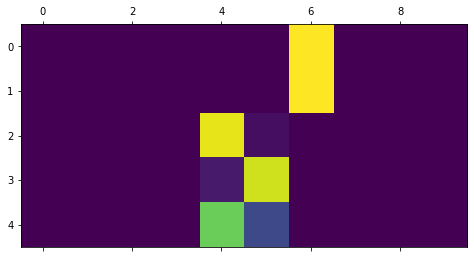

In [39]:
output_words, attentions = evaluate(
    encoder1, decoder1, "nous sommes des nouvelles venues .")
plt.matshow(attentions.numpy())

For a better viewing experience we will do the extra work of adding axes
and labels:




debug: in evaluate
input = nous descendons .
output = we re going down . <EOS>


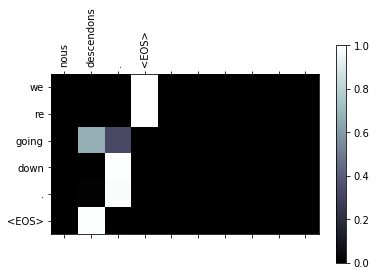

debug: in evaluate
input = nous sommes normaux .
output = we re starved . <EOS>


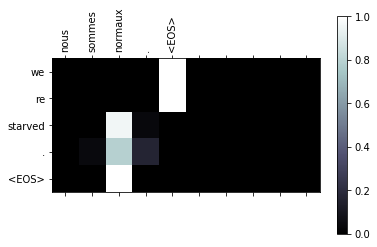

debug: in evaluate
input = nous perdons toutes du temps .
output = we re all wasting time . <EOS>


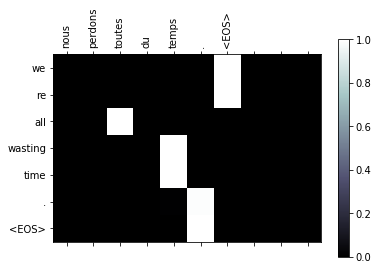

debug: in evaluate
input = nous ne sommes pas du coin .
output = we re not from around here . <EOS>


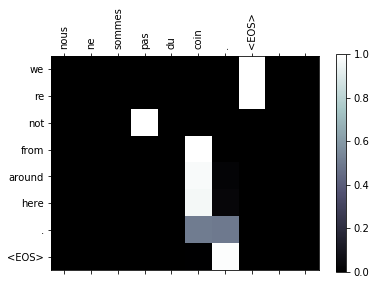

debug: in evaluate
input = nous allons gravir cette montagne .
output = we are going to climb that mountain . <EOS>


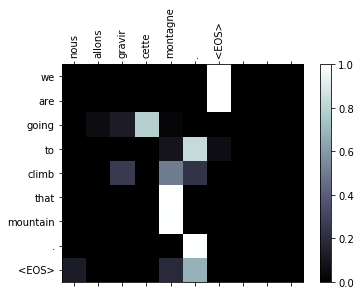

debug: in evaluate
input = nous sommes malchanceuses .
output = we re serious . <EOS>


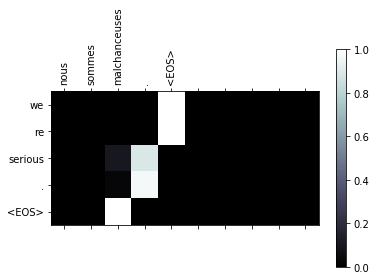

debug: in evaluate
input = on ne sort pas ensemble officiellement .
output = we re not living . <EOS>


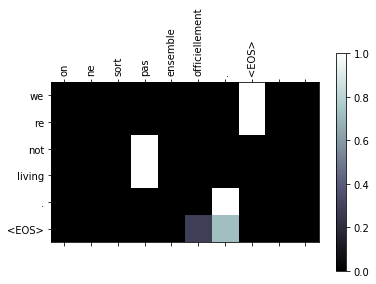

debug: in evaluate
input = nous sommes supposes connaitre les regles .
output = we are to to know the rules . <EOS>


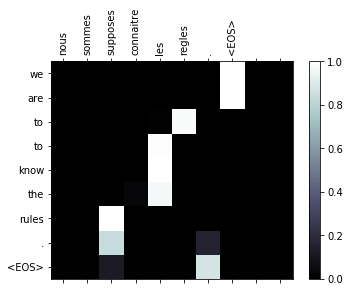

debug: in evaluate
input = nous sommes dans le petrin .
output = we re in trouble . <EOS>


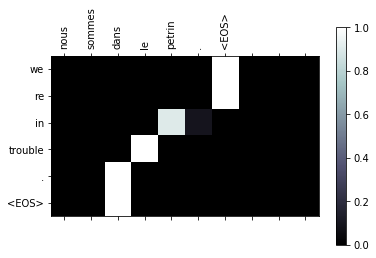

debug: in evaluate
input = nous sommes devouees .
output = we re dedicated . <EOS>


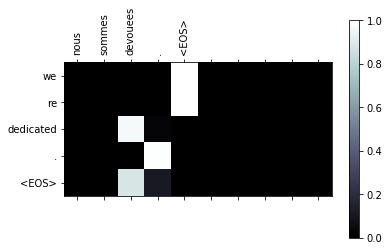

In [40]:
def showAttention(input_sentence, output_words, attentions):
    # Set up figure with colorbar
    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(attentions.numpy(), cmap='bone')
    fig.colorbar(cax)

    # Set up axes
    ax.set_xticklabels([''] + input_sentence.split(' ') +
                       ['<EOS>'], rotation=90)
    ax.set_yticklabels([''] + output_words)

    # Show label at every tick
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()


def evaluateAndShowAttention(input_sentence):
    output_words, attentions = evaluate(
        encoder1, decoder1, input_sentence)
    print('input =', input_sentence)
    print('output =', ' '.join(output_words))
    showAttention(input_sentence, output_words, attentions)

#for pair in testPairs:
for i in range(10):
    pair = trainPairs[i]
    evaluateAndShowAttention(pair[0])

#evaluateAndShowAttention("ils envoient de l aide .")
#evaluateAndShowAttention("nous allons peindre le mur .")

#evaluateAndShowAttention("nous nous rejouissons de vous revoir .")

#evaluateAndShowAttention("ils sont sortis faire les magasins .")

#evaluateAndShowAttention("nous sommes sous son commandement .")

Exercises
=========

-  Try with a different dataset

   -  Another language pair
   -  Human → Machine (e.g. IOT commands)
   -  Chat → Response
   -  Question → Answer

-  Replace the embeddings with pre-trained word embeddings such as word2vec or
   GloVe
-  Try with more layers, more hidden units, and more sentences. Compare
   the training time and results.
-  If you use a translation file where pairs have two of the same phrase
   (``I am test \t I am test``), you can use this as an autoencoder. Try
   this:

   -  Train as an autoencoder
   -  Save only the Encoder network
   -  Train a new Decoder for translation from there




# Credits
The original notebook was written by Sean Robertson <https://github.com/spro/practical-pytorch>_